Model for detecting human faces. Detecting human faces from a computer camera in real time.

The Faster-RCNN model is used.

In [ ]:
%%bash
curl -L "https://universe.roboflow.com/ds/sAoU7wIxdj?key=EgikbKTvyM" > roboflow.zip
unzip roboflow.zip
rm roboflow.zip

In [ ]:
%%bash
mkdir dataset
mv train/ dataset/
mv test/ dataset/
mv *.txt dataset/

In [ ]:
%%bash
mkdir dataset/train/images
mkdir dataset/train/labels
mv dataset/train/*.xml dataset/train/labels
mv dataset/train/*jpg dataset/train/images

mkdir dataset/test/images
mkdir dataset/test/labels
mv dataset/test/*.xml dataset/test/labels
mv dataset/test/*jpg dataset/test/images

In [ ]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import batched_nms

import matplotlib.pyplot as plt
import numpy as np
import requests
from tqdm import tqdm
from PIL import Image
import os
from tqdm.notebook import tqdm
import cv2

from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

In [ ]:
TRAIN_DIR = os.path.join('dataset', 'train')
TRAIN_IMAGES_DIR = os.path.join(TRAIN_DIR, 'images')
TRAIN_LABELS_DIR = os.path.join(TRAIN_DIR, 'labels')

TEST_DIR = os.path.join('dataset', 'test')
TEST_IMAGES_DIR = os.path.join(TEST_DIR, 'images')
TEST_LABELS_DIR = os.path.join(TEST_DIR, 'labels')

In [ ]:
def preprocess_data():
  print('Before preprocessing {}'.format(len(os.listdir(TRAIN_LABELS_DIR))))

  for filename in tqdm(os.listdir(TRAIN_LABELS_DIR)):
    label_filename = os.path.join(TRAIN_LABELS_DIR, filename)
    with open(label_filename, 'r') as f:
      xml = f.read()

    soup = BeautifulSoup(xml, 'xml')
    if len(soup.find_all('object')) == 0:
      image_filename = os.path.join(TRAIN_IMAGES_DIR, soup.find_all('filename')[0].string)
      os.remove(label_filename)
      os.remove(image_filename)
  print('After preprocessing {}'.format(len(os.listdir(TRAIN_LABELS_DIR))))

preprocess_data()

Before preprocessing 3672


  0%|          | 0/3672 [00:00<?, ?it/s]

After preprocessing 2988


In [ ]:
def get_target(filename):
  with open(filename, 'r') as f:
    xml = f.read()

  soup = BeautifulSoup(xml, 'xml')
  image_filename = soup.find_all('filename')[0].string
  bboxes = []
  for obj in soup.find_all('object'):
    label = obj.find_all('name')[0].string
    box = obj.find_all('bndbox')[0]
    xmin = int(box.find_all('xmin')[0].string)
    ymin = int(box.find_all('ymin')[0].string)
    xmax = int(box.find_all('xmax')[0].string)
    ymax = int(box.find_all('ymax')[0].string)
    bboxes.append([xmin, ymin, xmax, ymax])

  return {
      'image_filename': image_filename,
      'labels': torch.tensor([1] * len(bboxes), dtype=torch.int64),
      'boxes': torch.tensor(bboxes, dtype=torch.float32)
  }


In [ ]:
from albumentations.pytorch import ToTensorV2

class FaceDetectionDataset(Dataset):
  def __init__(self, train=True, transform=ToTensorV2()):
    self.transform = transform
    self.images_dir = TRAIN_IMAGES_DIR if train else TEST_IMAGES_DIR
    self.labels_dir = TRAIN_LABELS_DIR if train else TEST_LABELS_DIR
    self.label_filenames = os.listdir(self.labels_dir)

  def __len__(self):
    return len(self.label_filenames)

  def __getitem__(self, idx):
    label_path = os.path.join(self.labels_dir, self.label_filenames[idx])
    target = get_target(label_path)
    image_path = os.path.join(self.images_dir, target['image_filename'])
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.
    image = self.transform(image=image)['image']
    del target['image_filename']
    return image, target

In [ ]:
train_set = FaceDetectionDataset(train=True)
test_set = FaceDetectionDataset(train=False)


def collate_fn(batch):
  return tuple(zip(*batch))

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=4,
    pin_memory=True,
    num_workers=8,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    train_set,
    shuffle=False,
    batch_size=8,
    pin_memory=True,
    num_workers=8,
    collate_fn=collate_fn
)

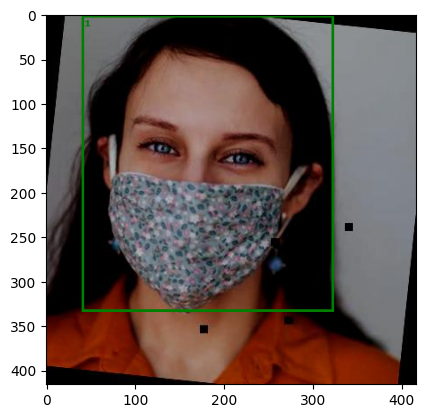

In [ ]:
from torchvision.utils import draw_bounding_boxes

def plot(image, target):
  colors = ['red', 'green', 'yellow']
  image = (image * 255.).type(torch.uint8)
  if len(target['labels']) != 0:
    image = draw_bounding_boxes(
        image,
        target['boxes'],
        [str(x) for x in target['labels'].tolist()],
        [colors[x] for x in target['labels'].tolist()],
        width=3
    )
  plt.imshow(image.permute(1, 2, 0))
  plt.show()

image, target = train_set[np.random.choice(len(train_set))]
plot(image, target)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 5
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-3, momentum=.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
from IPython.display import clear_output

class Averager:
  def __init__(self):
    self.val = .0
    self.count = 0

  def value(self):
    if self.count == 0: return 0
    return self.val / self.count

  def send(self, val):
    self.val += val
    self.count += 1

  def reset(self):
    self.val = .0
    self.count = 0

def plot_loss(train_losses, val_losses):
  clear_output()
  plt.plot(range(1, len(train_losses) + 1), train_losses, label='train', c='red')
  plt.plot(range(1, len(val_losses) + 1), val_losses, label='validation', c='blue')
  plt.legend()
  plt.show()

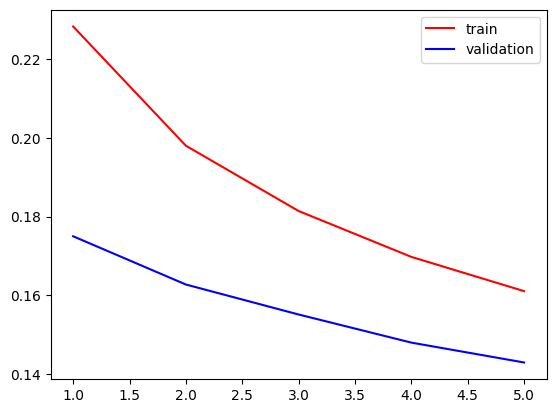

In [ ]:
loss_hist = Averager()
val_loss_hist = Averager()
losses = []
val_losses = []
model = model.to(device)
model.train()
for epoch in range(num_epochs):
  for images, targets in tqdm(train_loader, desc=f'Train: {epoch + 1}/{num_epochs}'):
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
    loss_dict = model(images, targets)
    loss = sum(loss_ for loss_ in loss_dict.values())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_hist.send(loss.item())

  losses.append(loss_hist.value())
  scheduler.step()
  with torch.no_grad():
    for images, targets in tqdm(test_loader, desc=f'Validation: {epoch + 1}/{num_epochs}'):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
        loss_dict = model(images, targets)
        loss = sum(loss_ for loss_ in loss_dict.values())
        val_loss_hist.send(loss.item())

  val_losses.append(val_loss_hist.value())
  plot_loss(losses, val_losses)

  torch.save({
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict()
  }, 'model.pt')

In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
  torch.cuda.empty_cache()

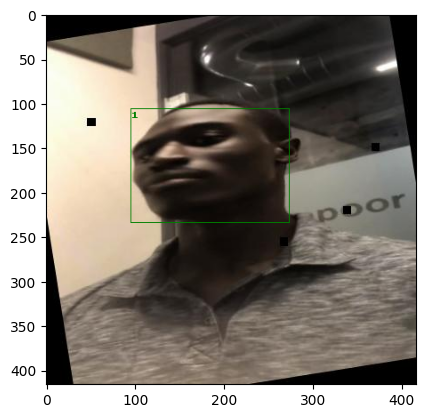

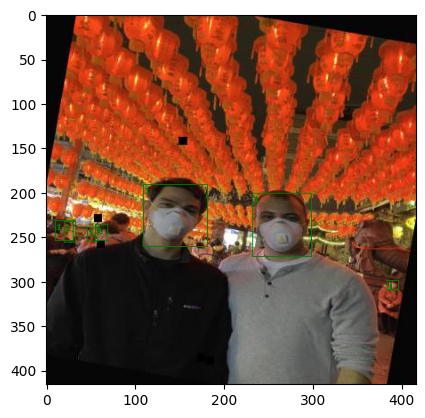

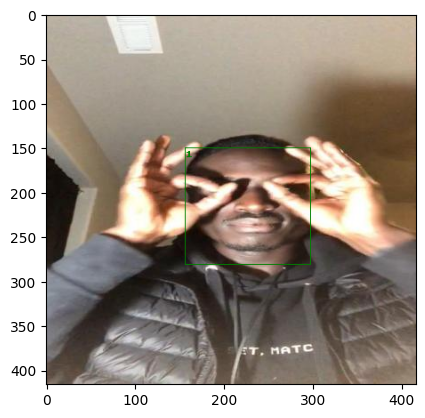

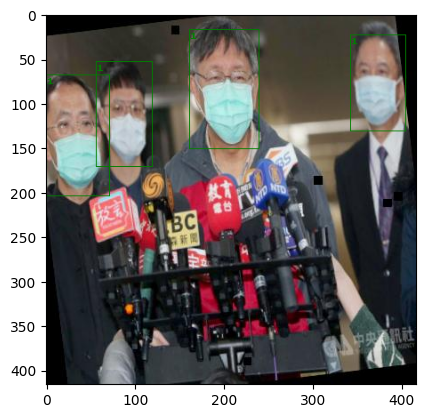

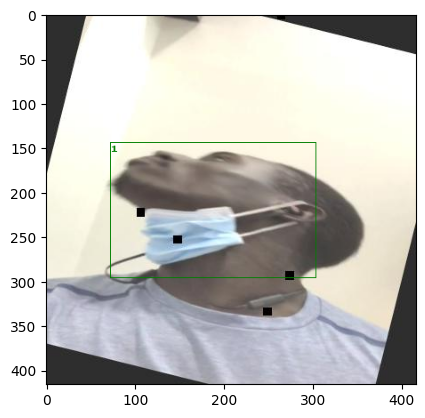

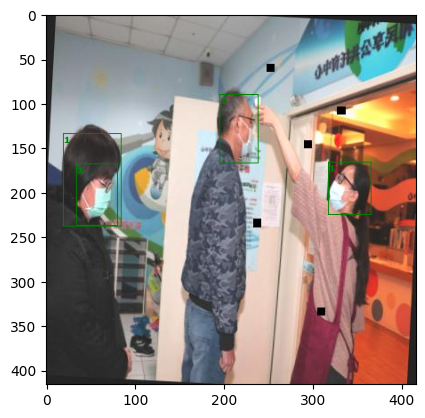

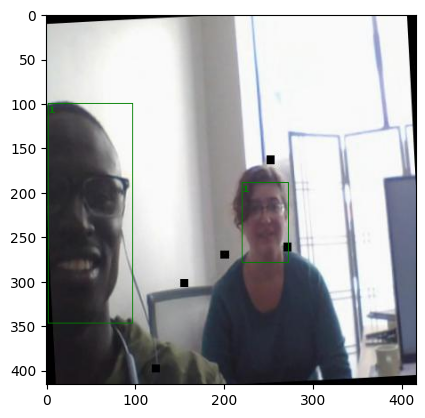

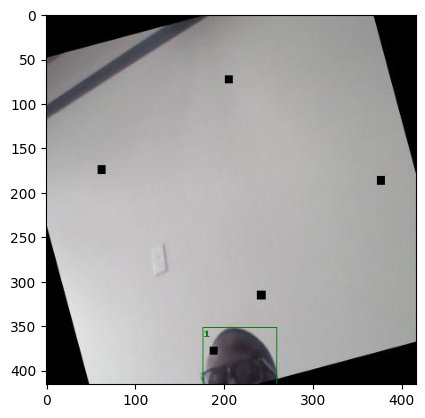

In [ ]:
images, _ = next(iter(test_loader))

def predict(images):
  model.eval()
  with torch.no_grad():
    images = [image.to(device) for image in images]
    results = model(images)

  for image, result in zip(images, results):
    scores = result['scores'].cpu()
    boxes = result['boxes'].cpu()
    labels = result['labels'].cpu()
    ids = batched_nms(boxes, scores, labels, iou_threshold=.7)
    mask = scores[ids] > .6
    boxes = boxes[ids][mask]
    scores = scores[ids][mask]
    labels = labels[ids][mask]
    plot(image.cpu(), {
        'boxes': boxes,
        'labels': labels
    })

predict(images)

In [ ]:
result['scores']

tensor([0.9731], device='cuda:0')

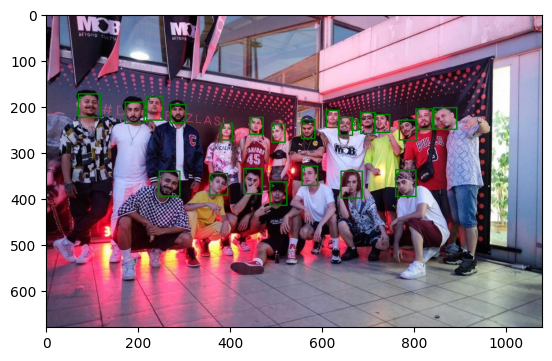

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import torchvision.transforms as T

url = 'https://www.rapertuar.com/wp-content/uploads/2020/09/mob-entertainment-1080x680.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
predict([T.ToTensor()(img)])

# It's me ;)

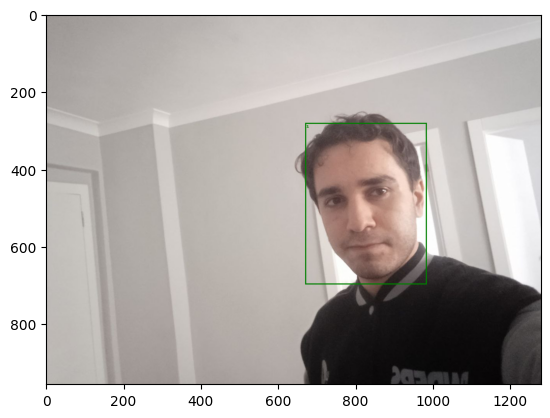

In [ ]:
img = Image.open('me.jpg').convert('RGB')
predict([T.ToTensor()(img)])

# The code below detects faces using the camera on your PC in real time

In [ ]:

# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
model.eval()
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = T.ToTensor()(img)
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    with torch.no_grad():
      faces = model([img.to(device)])
    for face in faces:
      lst = face['boxes'].cpu().tolist()
      if len(lst) == 0: continue
      (x,y,w,h) = lst[0]
      bbox_array = cv2.rectangle(bbox_array,(int(x),int(y)),(int(w), int(h)),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes